In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [47]:
train_photo = cv2.imread("inputs/back/back_03.jpeg")
train_photo = cv2.cvtColor(train_photo, cv2.COLOR_BGR2RGB)
train_photo_gray = cv2.cvtColor(train_photo, cv2.COLOR_RGB2GRAY)

query_photo = cv2.imread("inputs/back/back_02.jpeg")
query_photo = cv2.cvtColor(query_photo, cv2.COLOR_BGR2RGB)
query_photo_gray = cv2.cvtColor(query_photo, cv2.COLOR_RGB2GRAY)

### Viewing the Images

Text(0.5, 0, 'Train Photo')

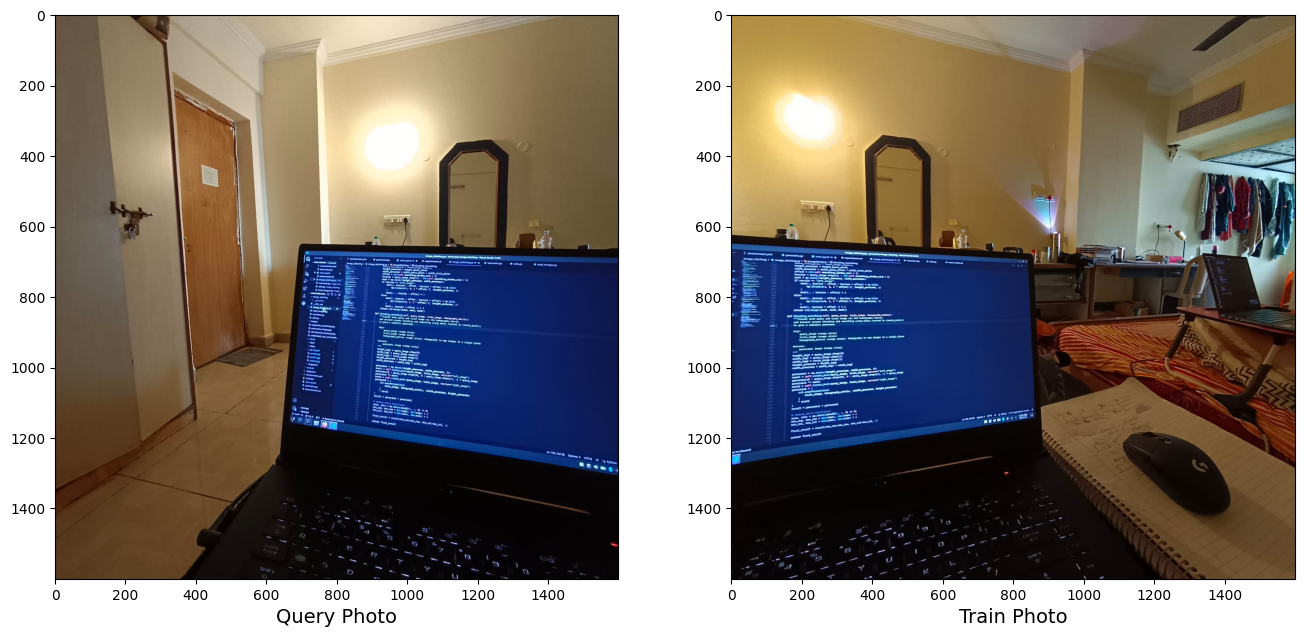

In [49]:
fig, ax = plt.subplots(1, 2, constrained_layout=False, figsize=(16, 9))
ax[0].imshow(query_photo, cmap="gray")
ax[0].set_xlabel("Query Photo", fontsize=14)

ax[1].imshow(train_photo, cmap="gray")
ax[1].set_xlabel("Train Photo", fontsize=14)

In [50]:
def sift_detector(image):
    descriptor = cv2.SIFT_create()
    keypoints, features = descriptor.detectAndCompute(image, None)

    return keypoints, features


keypoints_train_image, features_train_image = sift_detector(train_photo_gray)
keypoints_query_image, features_query_image = sift_detector(query_photo_gray)
print(f"lenght the keypoints: {len(keypoints_train_image)}")
print(f"descriptor shape: {features_train_image.shape}")

lenght the keypoints: 8614
descriptor shape: (8614, 128)


In [51]:
for keypoint in keypoints_query_image:
    x, y = keypoint.pt
    size = keypoint.size
    orientation = keypoint.angle
    response = keypoint.response
    octave = keypoint.octave
    class_id = keypoint.class_id

print(f"x, y: {x, y}")
print(f"size: {size}")
print(f"orientation: {orientation}")
print(f"response: {response}")
print(f"octave: {octave}")
print(f"class_id: {class_id}")

x, y: (1593.2916259765625, 1268.8731689453125)
size: 1.996505618095398
orientation: 136.7122802734375
response: 0.023502683266997337
octave: 7668223
class_id: -1


In [52]:
features_query_image.shape
len(keypoints_query_image)

6034

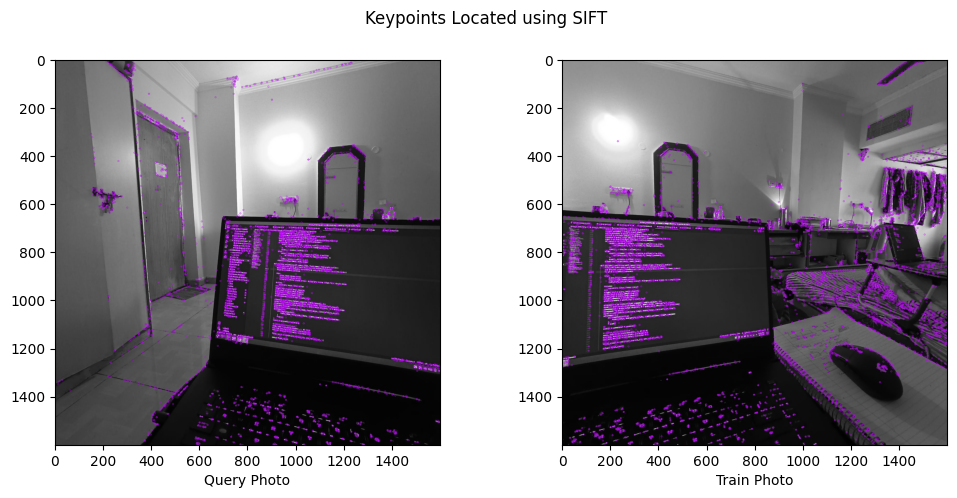

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=False)

ax[0].imshow(
    cv2.drawKeypoints(
        query_photo_gray, keypoints_query_image, None, color=(191, 0, 255)
    )
)
ax[0].set_xlabel("Query Photo")

ax[1].imshow(
    cv2.drawKeypoints(
        train_photo_gray, keypoints_train_image, None, color=(191, 0, 255)
    )
)
ax[1].set_xlabel("Train Photo")

plt.suptitle("Keypoints Located using SIFT")
plt.savefig(
    "./outputs/" + "sift" + "_features_located" + ".jpeg",
    bbox_inches="tight",
    dpi=300,
    format="jpeg",
)

### Matching keypoints

In [54]:
def create_match():
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    return bf

In [55]:
def keypoints_matching(features_train_image, features_query_image):
    bf = create_match()

    best_matches = bf.match(features_train_image, features_query_image)

    raw_matches = sorted(best_matches, key=lambda x: x.distance)
    print(f"raw matchines with brute force: {len(raw_matches)}")

    return raw_matches

drawing matches for bf


raw matchines with brute force: 2323
matches: < cv2.DMatch 0x7cc1881a7bd0>


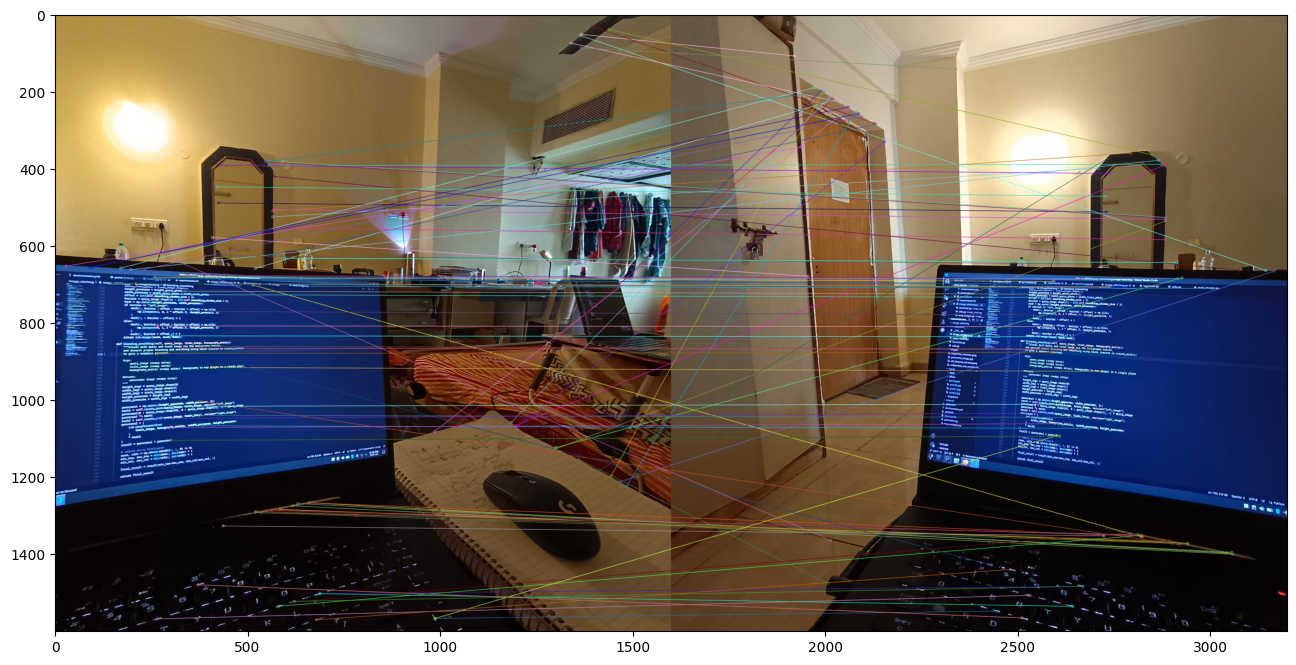

In [56]:
print(f"drawing matches for bf")
fig = plt.figure(figsize=(20, 8))
matches = keypoints_matching(features_train_image, features_query_image)
print(f"matches: {matches[0]}")
mapped_feature_image = cv2.drawMatches(
    train_photo,
    keypoints_train_image,
    query_photo,
    keypoints_query_image,
    matches[:100],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
plt.imshow(mapped_feature_image)
plt.savefig(
    "./outputs/" + "keypoints_matched" + ".jpeg",
    bbox_inches="tight",
    dpi=300,
    format="jpeg",
)

In [58]:
def homography_stitching(
    keypoints_train_image, keypoints_query_image, matches, reprojThresh
):
    # convert to 2 numpy array of coordinates to find hommography
    keypoints_train_image = np.float32(
        [keypoint.pt for keypoint in keypoints_train_image]
    )
    keypoints_query_image = np.float32(
        [keypoint.pt for keypoint in keypoints_query_image]
    )

    # minimum match count for homography is 4
    if len(matches) >= 4:
        points_train = np.float32([keypoints_train_image[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_image[m.trainIdx] for m in matches])

        H, status = cv2.findHomography(
            points_train, points_query, cv2.RANSAC, reprojThresh
        )

        return (matches, H, status)

    else:
        print(f"minimum match count not satisfied cannot get homopgrahy")
        return None

In [59]:
M = homography_stitching(
    keypoints_train_image, keypoints_query_image, matches, reprojThresh=4
)

if M is None:
    print(f"Error")

(matches, Homography_matrix, status) = M

# matrix with 8 degrees of freedom
print(f"{Homography_matrix}")

[[ 2.47625446e-01 -4.25564838e-02  8.32995179e+02]
 [-3.55521467e-01  8.08973544e-01  1.45006551e+02]
 [-4.89429204e-04 -7.71731451e-07  1.00000000e+00]]


### Warp perspective

In [60]:
width = query_photo.shape[1] + train_photo.shape[1]
print(f"Width: {width}")

height = max(query_photo.shape[0], train_photo.shape[0])
print(f"Height: {height}")

Width: 3200
Height: 1600


results shape: (1600, 3200, 3)


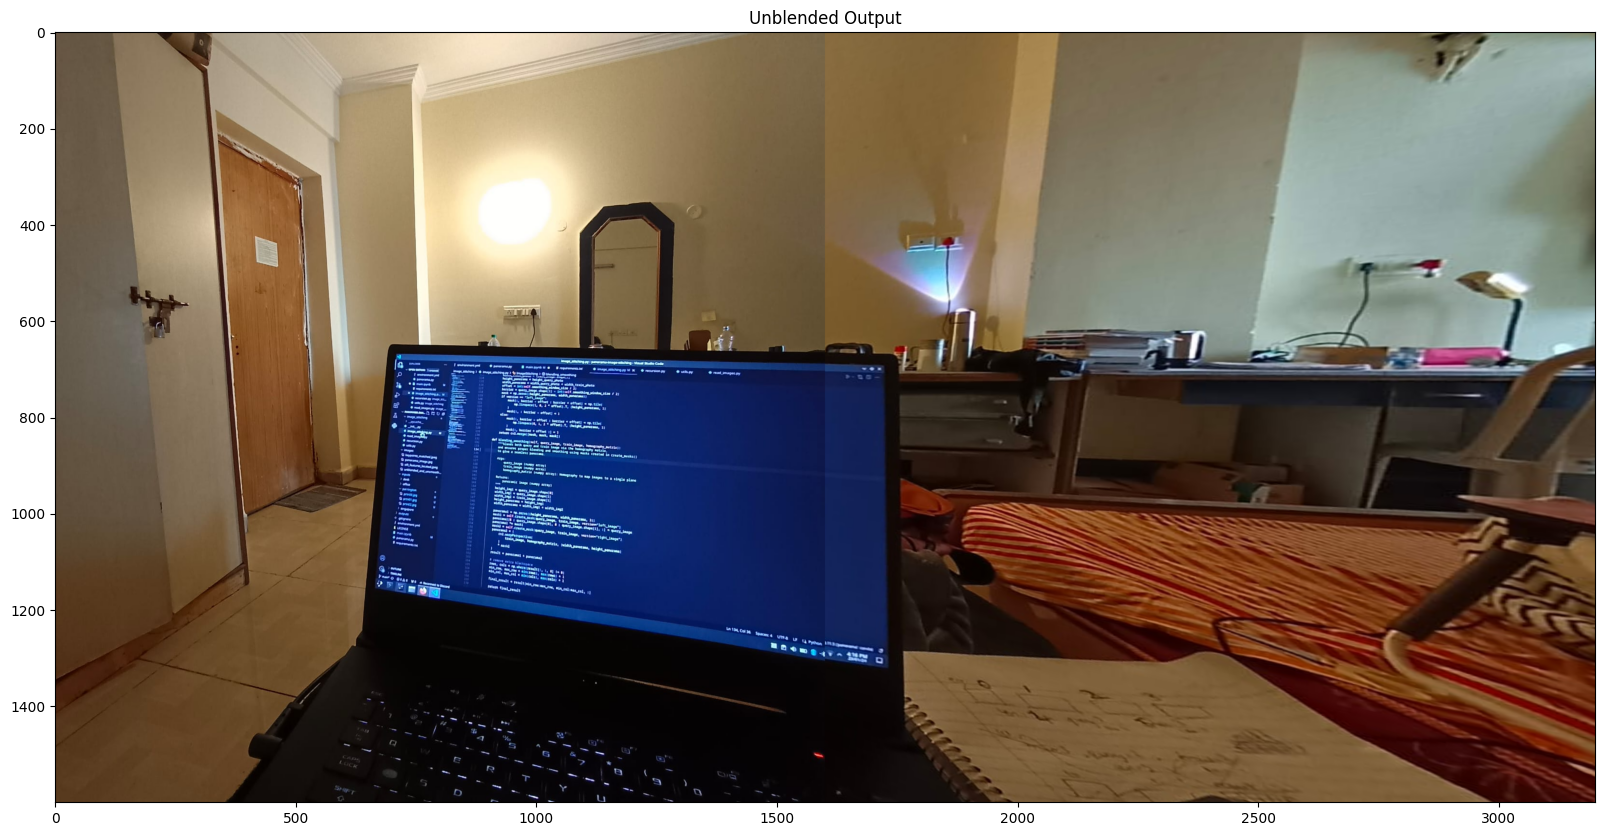

In [66]:
result = cv2.warpPerspective(train_photo, Homography_matrix, dsize=(width, height))

result[0 : query_photo.shape[0], 0 : query_photo.shape[1]] = query_photo
print(f"results shape: {result.shape}")

plt.figure(figsize=(20, 10))
plt.title("Unblended Output")
plt.imshow(result)
plt.savefig(
    "./outputs/" + "unblended_and_unsmoothed_output" + ".jpeg",
    bbox_inches="tight",
    dpi=300,
    format="jpeg",
)

### Blending and Smoothing

In [97]:
smoothing_window_size = 200


def create_mask(img1, img2, version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version == "left_image":
        mask[:, barrier - offset : barrier + offset] = np.tile(
            np.linspace(1, 0, 2 * offset).T, (height_panorama, 1)
        )
        mask[:, : barrier - offset] = 1
    else:
        mask[:, barrier - offset : barrier + offset] = np.tile(
            np.linspace(0, 1, 2 * offset).T, (height_panorama, 1)
        )
        mask[:, barrier + offset :] = 1
    return cv2.merge([mask, mask, mask])

In [98]:
height_img1 = query_photo.shape[0]
width_img1 = query_photo.shape[1]
width_img2 = train_photo.shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2

panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(query_photo, train_photo, version="left_image")
panorama1[0 : query_photo.shape[0], 0 : query_photo.shape[1], :] = query_photo
panorama1 *= mask1
mask2 = create_mask(query_photo, train_photo, version="right_image")
panorama2 = (
    cv2.warpPerspective(
        train_photo, Homography_matrix, (width_panorama, height_panorama)
    )
    * mask2
)
result = panorama1 + panorama2

# remove extra blackspace
rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]

Final results shape: (1600, 3200, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: Floating point image RGB values must be in the 0..1 range.

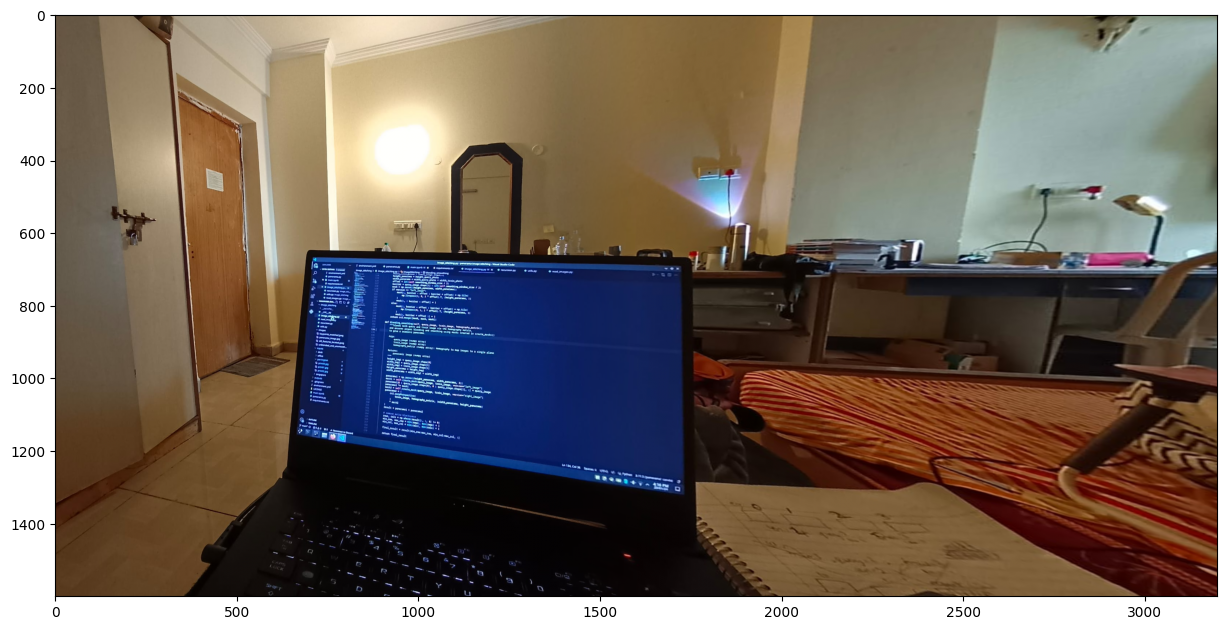

In [100]:
print(f"Final results shape: {final_result.shape}")
plt.figure(figsize=(15, 10))
plt.imshow(final_result / 255.0)
plt.imsave("./outputs/final_output.jpg", final_result / 255.0)